In [1]:
import numpy as np
import numpy.linalg as LA
import jax
import jax.numpy as jnp
import jax.numpy.linalg as JLA

import pandas as pd
import matplotlib.pyplot as plt
import japanize_matplotlib
from jax.example_libraries import optimizers
from tqdm.notebook import trange
from functools import partial

In [2]:
n = 100
m = 100
num_itr = 30
K = 500
adam_lr = 5e-4
max_inner = 40
noise_std = 3.0

A = jnp.array(np.random.randn(m, n))
eig, _ = LA.eig(A.T@A)
lambda_max = max(eig)
eta_opt = 1/lambda_max

In [3]:
@jax.jit
def gen_y(x):
    y = A@x + noise_std * jnp.array(np.random.randn(m, 1))
    return y
batch_gen_y = jax.vmap(gen_y, in_axes=-1, out_axes=-1)

In [4]:
xs = np.linspace(-5, 5, 500)

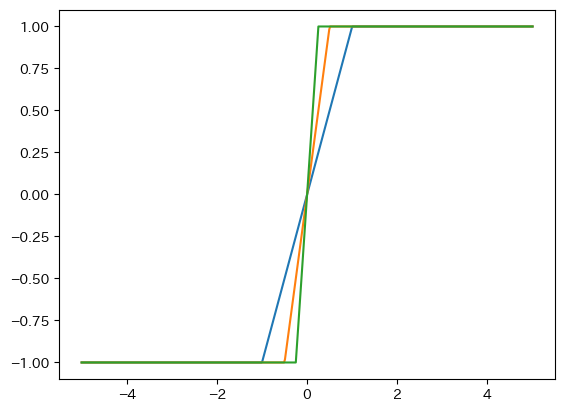

In [5]:
plt.figure()
plt.plot(xs, jax.nn.hard_tanh(xs))
plt.plot(xs, jax.nn.hard_tanh(2*xs))
plt.plot(xs, jax.nn.hard_tanh(4*xs));

In [6]:
@jax.jit
def get_dot(x):
    return x @ x.T
batch_get_dot = jax.vmap(get_dot, in_axes=-1, out_axes=-1)

In [7]:
# @partial(jax.jit, static_argnums=[0,2])
def ProjectedGD(max_itr, y, func):
    x = jnp.zeros((n, K))
    for _ in range(max_itr):
        x -= eta_opt* A.T @ (A@x - y)
        x = jnp.array(list(map(func, x)))
    return x

def comp_mse(max_itr, func):
    x_org = jnp.ones((n, K)) - 2.0 * jnp.array(np.random.binomial(1,0.5,size=(n, K)))
    y = batch_gen_y(x_org)
    x_hat = ProjectedGD(max_itr, y, func)
    return np.sum(batch_get_dot(x_org - x_hat))/K

In [8]:
df = pd.DataFrame()
df["Itaration"] = range(num_itr)

In [9]:
GD_mse1 = [float(comp_mse(i+1, jax.nn.hard_tanh)) for i in range(num_itr)]

In [10]:
df["PGD(hardtanh)"] = GD_mse1

In [11]:
GD_mse2 = [float(comp_mse(i+1, jnp.sign)) for i in range(num_itr)]

In [12]:
df["PGD(sign)"] = GD_mse2

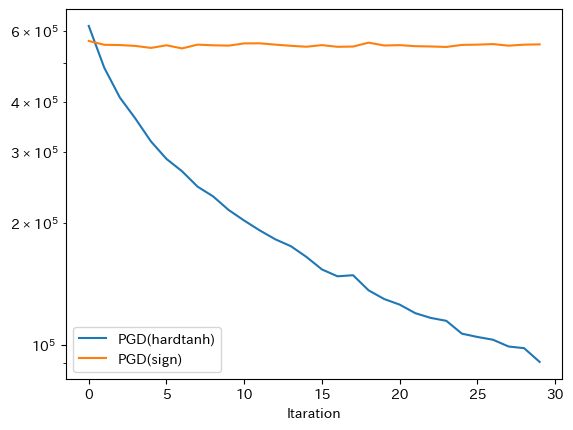

In [13]:
df.plot(df.columns[0], df.columns[1:])
plt.yscale("log")